In [67]:
import numpy as np
from skimage import io, data, transform, util, filters, color, exposure, restoration, feature
import matplotlib.pyplot as plt
from skimage.util import img_as_float, img_as_float64, img_as_ubyte
from scipy import ndimage, fft

In [68]:
def show(img_list, caption_list, Axis=False, rescale = True):
    n = len(img_list)
    f, ax = plt.subplots(1,n, figsize=(10+5*(n-1),10))
    for i in range(n):
        if rescale:
            ax[i].imshow(img_list[i], cmap='gray')
        else:
            ax[i].imshow(img_list[i], cmap='gray', vmin=0, vmax=255)
        ax[i].set_title(caption_list[i])
        if not Axis:
            ax[i].set_axis_off()

In [69]:
def my_mesh(mat):
    lin, col = mat.shape[:2]
    x, y = np.ogrid[0:lin, 0:col]
    ax = plt.figure(figsize=(10,10))
    ax = plt.axes(projection='3d')

    ax.plot_surface(x, y, mat, rstride=1, cstride=1, cmap='viridis', edgecolor='none')

In [70]:
img = data.astronaut()
img = color.rgb2gray(img)

(60,)


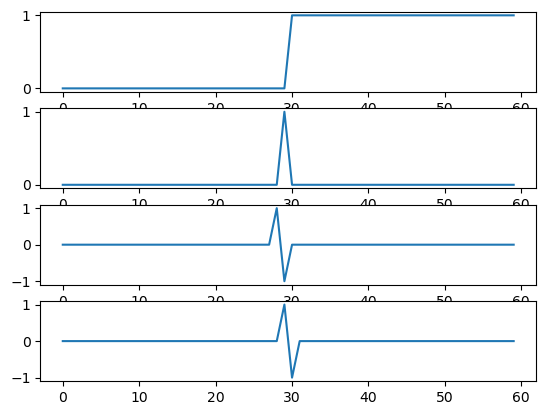

In [63]:
linha = np.hstack((np.zeros((1,30)), np.ones((1,30)))).flatten()
print(linha.shape)
dr1 = ndimage.convolve1d(linha, [1,-1])
dr2 = ndimage.convolve1d(dr1, [1,-1])
dr22 = ndimage.convolve1d(linha, [1,-2, 1])


plt.subplot(411)
plt.plot(linha)
plt.subplot(412)
plt.plot(dr1)
plt.subplot(413)
plt.plot(dr2)
plt.subplot(414)
plt.plot(dr22)


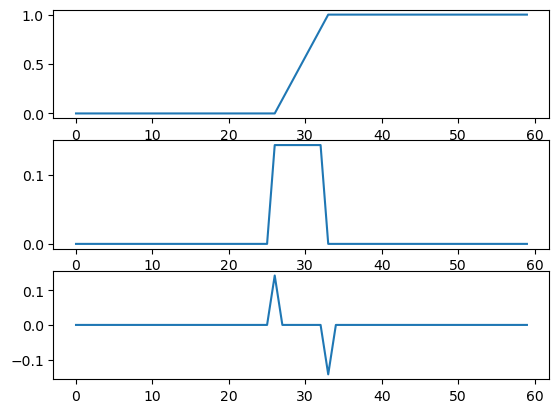

In [65]:
smooth = ndimage.convolve1d( linha, np.ones((7))*1/7 )
dr1 = ndimage.convolve1d(smooth, [1,-1])
dr2 = ndimage.convolve1d(smooth, [1,-2, 1])

plt.subplot(311)
plt.plot(smooth)
plt.subplot(312)
plt.plot(dr1)
plt.subplot(313)
plt.plot(dr2)

## Detecção de bordas Sobel

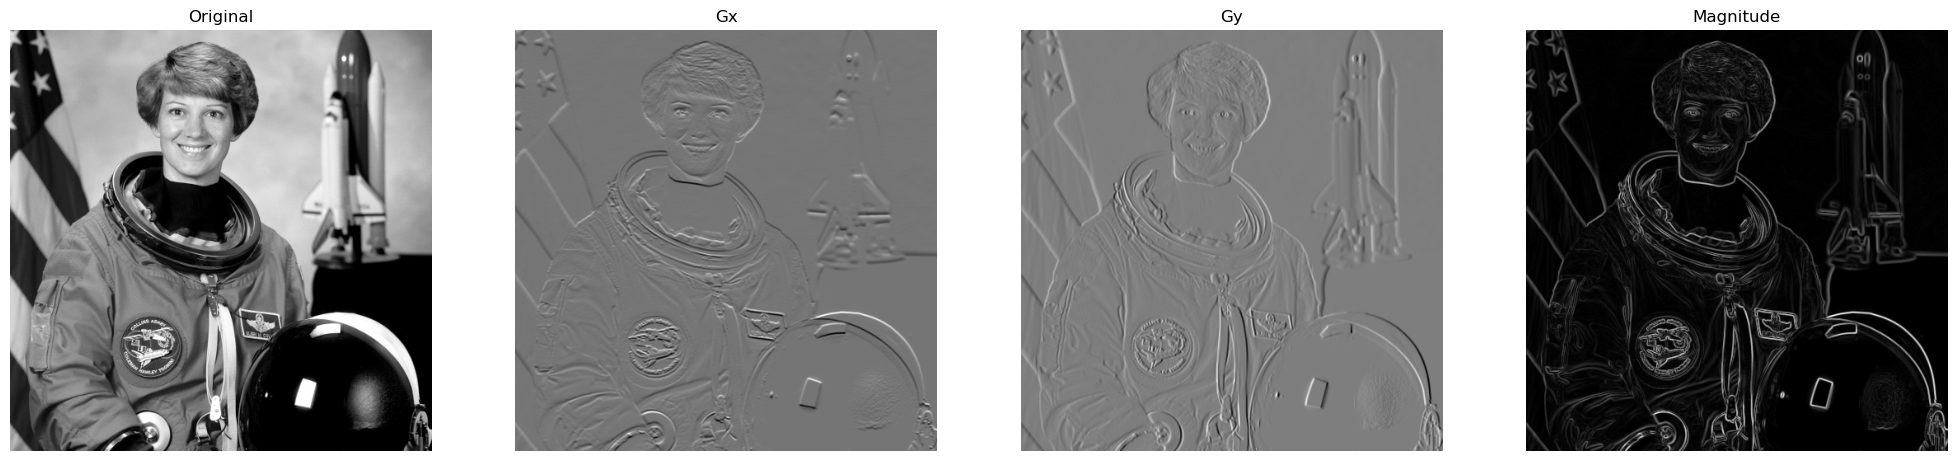

In [71]:
kernel = np.array([[1,   2, 1],
                   [0,   0, 0],
                   [-1, -2, -1]])
gx = ndimage.convolve(img, kernel)
gy = ndimage.convolve(img, kernel.T)
mag = np.sqrt(gx**2 + gy**2)
show([img, gx, gy, mag], ['Original', 'Gx', 'Gy', 'Magnitude'])


In [72]:
print(np.max(mag))

4.068985754323775


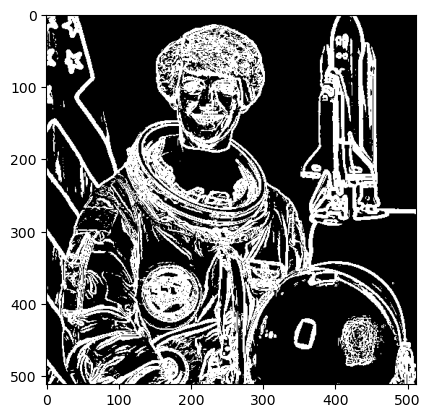

In [76]:
plt.imshow(mag > np.max(mag)*.05, cmap='gray')
#plt.imshow(mag , cmap='gray')

## Detecção de bordas Prewitt

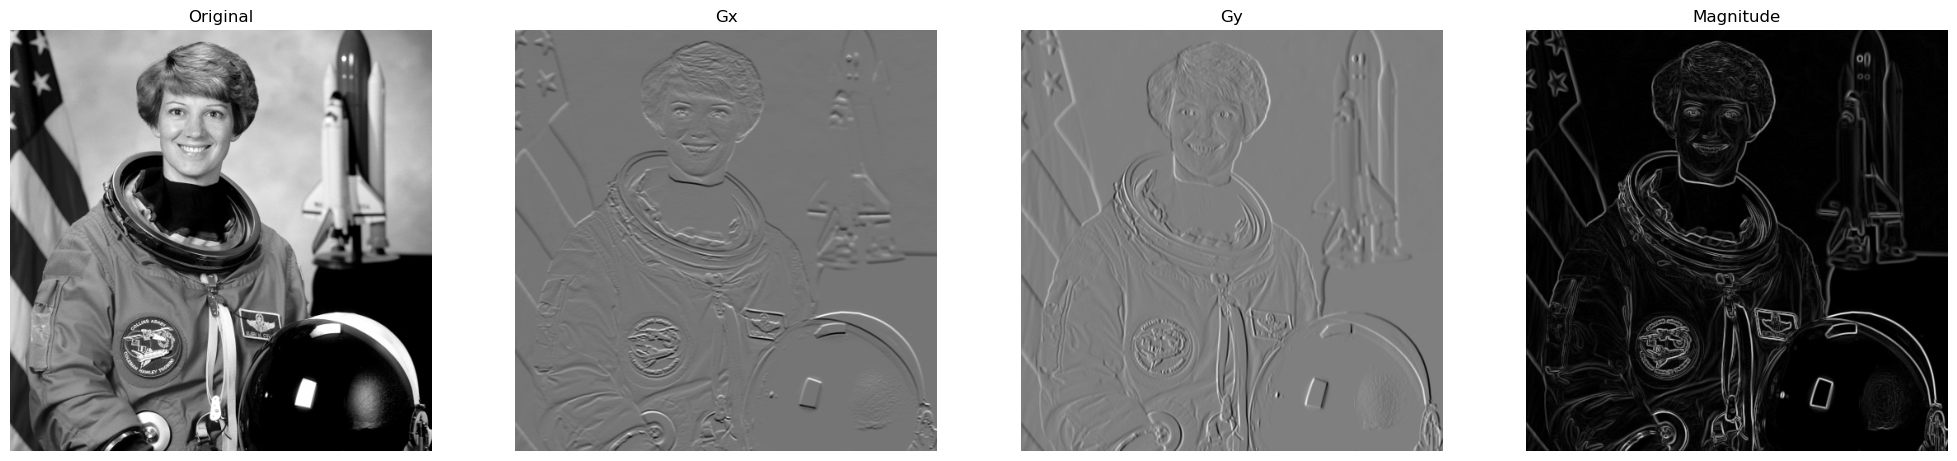

In [77]:
kernel = np.array([[1,   1, 1],
                   [0,   0, 0],
                   [-1, -1, -1]])
gx = ndimage.convolve(img, kernel)
gy = ndimage.convolve(img, kernel.T)
mag = np.sqrt(gx**2 + gy**2)
show([img, gx, gy, mag], ['Original', 'Gx', 'Gy', 'Magnitude'])

## Detecção de bordas de Roberts

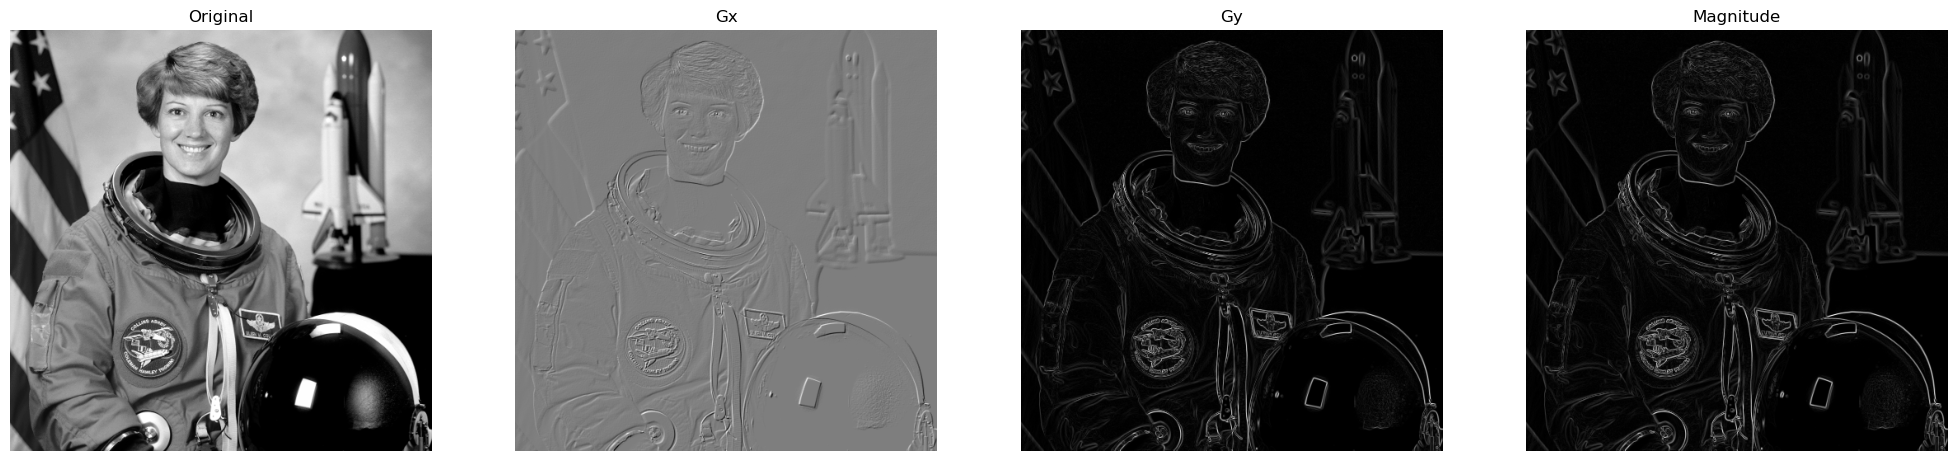

In [78]:
kernel_x = np.array([[1, 0],
                   [0, -1]])
kernel_y = np.array([[0, 1],
                   [-1, 0]])
gx = ndimage.convolve(img, kernel_x)
gy = ndimage.convolve(img, kernel_y)
mag = np.sqrt(gx**2 + gy**2)
mag2 = np.abs(gx) + np.abs(gy)
show([img, gx, mag2, mag], ['Original', 'Gx', 'Gy', 'Magnitude'])

In [79]:
def bordes(img, kernel):
    gx = ndimage.convolve(img, kernel)
    gy = ndimage.convolve(img, kernel.T)
    mag = np.sqrt(gx**2 + gy**2)
    return mag

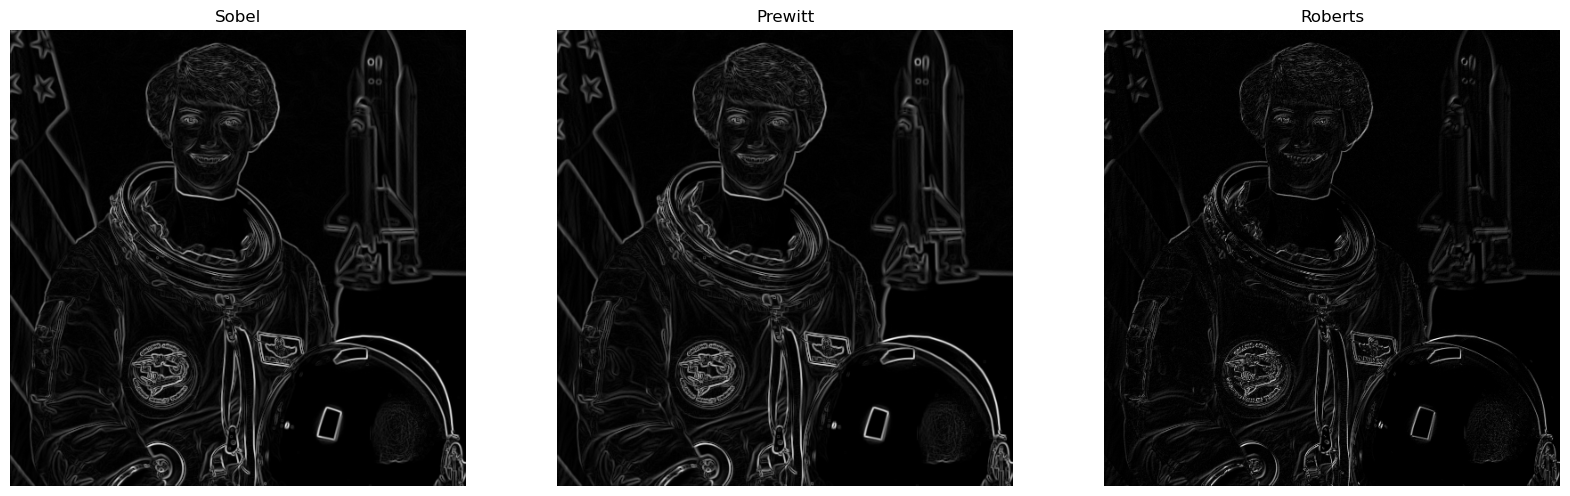

In [80]:
sobel = np.array([[1,   2, 1],
                  [0,   0, 0],
                  [-1, -2, -1]])
prewitt = np.array([[1,   1, 1],
                  [0,   0, 0],
                  [-1, -1, -1]])  
roberts = np.array([[1,   0],
                    [0,   -1]])                
img_sobel = bordes(img, sobel)
img_prewitt = bordes(img, prewitt)
img_roberts = bordes(img, roberts)
show([img_sobel, img_prewitt, img_roberts], ['Sobel', 'Prewitt', 'Roberts'])

### Soluções em Skimage

**skimage.filters.prewitt**(image, mask=None, mode='reflect', cval=0.0): Find the edge magnitude using the Prewitt transform.
* image: array. The input image.
* mask: array of bool, optional. Clip the output image to this mask. (Values where mask=0 will be set to 0.)
* mode; str or sequence of str, optional. The boundary mode for the convolution. 
* cval: float, optional. When mode is 'constant', this is the constant used in values outside the boundary of the image data.

Returns
* output: array of float. The Prewitt edge map



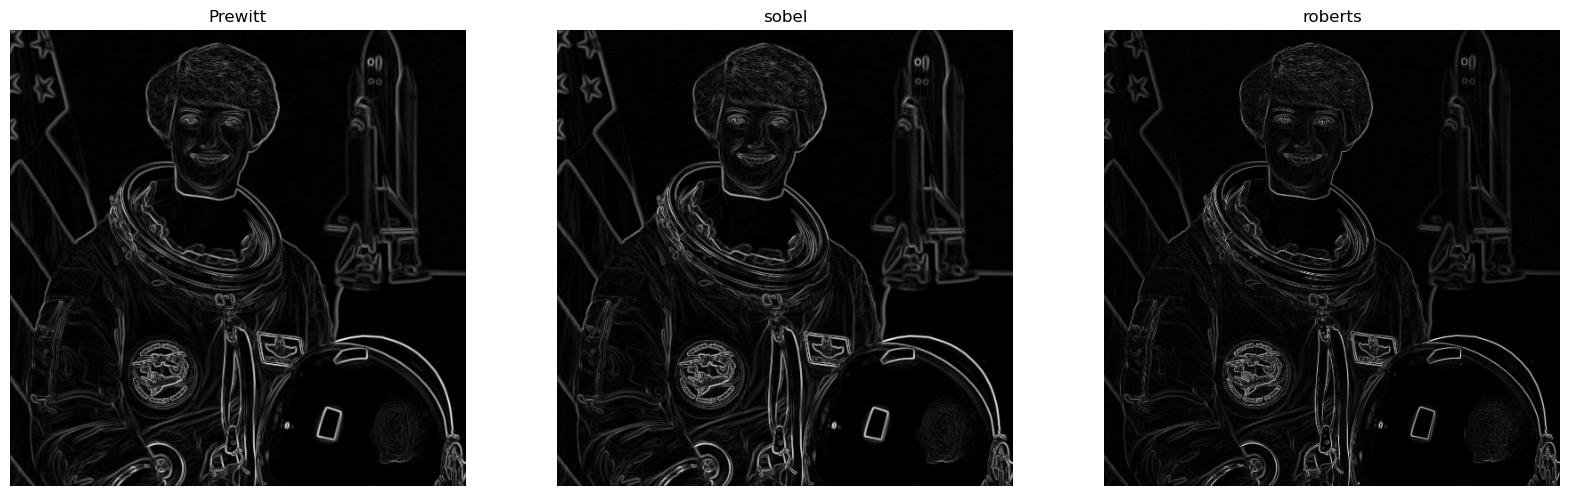

In [81]:
edge_prewitt = filters.prewitt(img)
edge_sobel = filters.sobel(img)
edge_roberts = filters.roberts(img)

show([edge_prewitt, edge_sobel, edge_roberts],['Prewitt', 'sobel', 'roberts'])

### Operador Laplaciano

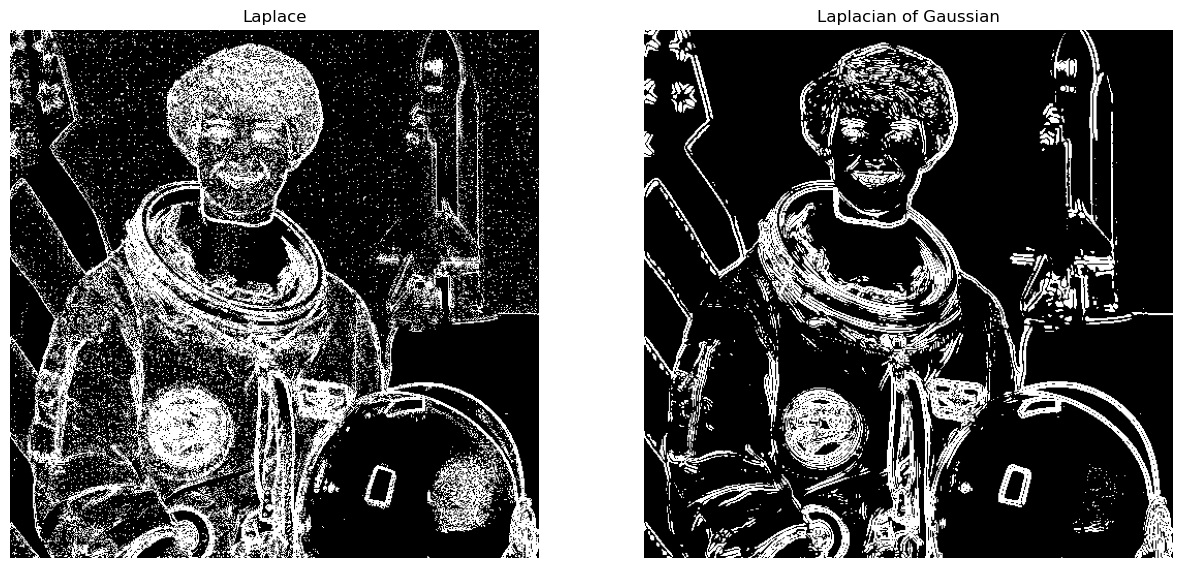

In [83]:
kernel = np.array([[0, -1, 0],
                  [-1, 4, -1],
                  [0, -1, 0]])
nimg_laplace = ndimage.convolve(img, kernel)
#plt.imshow(np.abs(nimg_laplace)>0.1, cmap='gray')

nimg_log = ndimage.convolve( filters.gaussian(img), kernel)

show([np.abs(nimg_laplace)>.05, np.abs(nimg_log)>0.03], ['Laplace', 'Laplacian of Gaussian'])

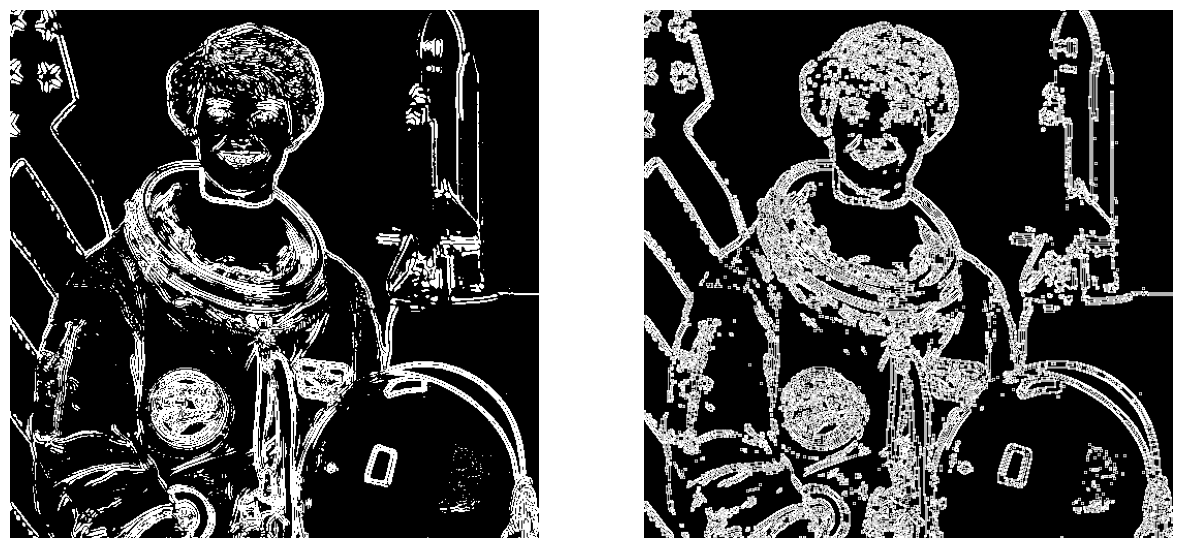

In [87]:

img_prewitt = bordes(np.abs(nimg_log)>0.03, prewitt)
show([np.abs(nimg_log)>0.03, img_prewitt],['',''])

## Detector de bordes Canny

<p>
<ol>
<li><b>Redução de ruído</b>: aplique o filtro gaussiano para suavizar a imagem a fim de remover o ruído</li>
<li><b>Cálculo de gradiente</b>: Encontre os gradientes de intensidade da imagem</li>
<li><b>Supressão não máxima</b>: Aplique limiar de magnitude de gradiente ou supressão de corte de limite inferior para se livrar de respostas espúrias à detecção de borda</li>
<li><b>Limiar duplo</b>: Aplicar limite duplo para determinar bordas potenciais</b>
<li><b>Rastreamento de borda por histerese</b>: Rastreie borda por histerese: finalize a detecção de bordas suprimindo todas as outras bordas que são fracas e não conectadas a bordas fortes.</li>
</ol>
</p>

**skimage.feature.canny**(image, sigma=1.0, low_threshold=None, high_threshold=None, mask=None, mode='constant', cval=0.0): Edge filter an image using the Canny algorithm.
* image: 2D array. Grayscale input image to detect edges on; can be of any dtype.
* sigma: float, optional. Standard deviation of the Gaussian filter.
* low_threshold: float, optional. Lower bound for hysteresis thresholding (linking edges). If None, low_threshold is set to 10% of dtype’s max.
* high_thresholdfloat, optional. Upper bound for hysteresis thresholding (linking edges). If None, high_threshold is set to 20% of dtype’s max.
* mask: array, dtype=bool, optional. Mask to limit the application of Canny to a certain area.
* mode: str, {‘reflect’, ‘constant’, ‘nearest’, ‘mirror’, ‘wrap’}
* cvalfloat, optional. Value to fill past edges of input if mode is ‘constant’.

Returns
* output: 2D array (image). The binary edge map.

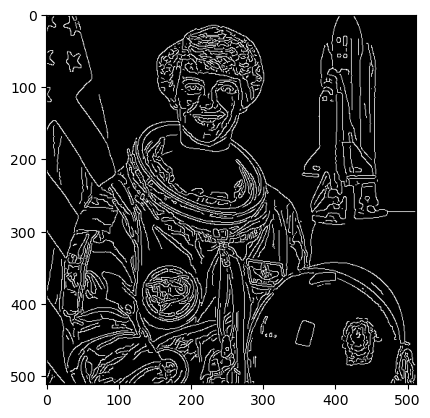

In [88]:
edge_canny = feature.canny(img)
plt.imshow(edge_canny, cmap= 'gray')

## Thresholding Global

In [89]:
def thresholdGlobal(img):
    T = np.max(img) * 0.5
    T_old = 0
    while np.abs(T_old - T) > 0.01:
        G1 = img > T
        G2 = img <= T
        u1 = np.mean(img[G1])
        u2 = np.mean(img[G2])
        T_old = T
        T = (u1 + u2) / 2
    return T



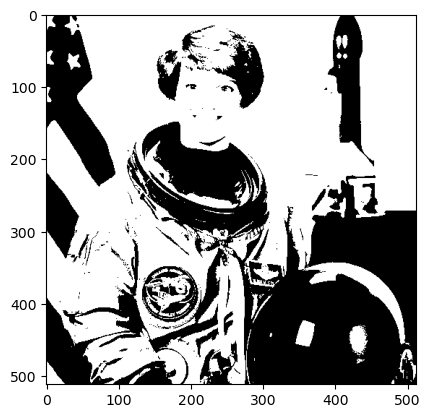

In [92]:
threshold = thresholdGlobal(img)
plt.imshow(img > threshold, cmap='gray')

## Método de Otsu

<p>
The formula for finding the within-class variance at any threshold t is given by:

$$\sigma^2(t) = \omega_{bg}(t) \sigma^2_{bg}(t)+ \omega_{fg}(t) \sigma^2_{fg}(t) $$  

where $\omega_{bg}(t)$ and $\omega_{fg}(t)$ represents the probability of number of pixels for each class at threshold $t$ and $\sigma^2$ represents the variance of color values.

To understand what this probaility means, Let,

$P_{all}$ be the total count of pixels in an image,
$P_{BG}(t)$ be the count of background pixels at threshold $t$,
$P_{FG}(t)$ be the count of foreground pixels at threshold $t$

So the weights are given by,

$$\omega_{bg}(t)=\frac{P_{BG}(t)}{P_{all}}$$
$$\omega_{fg}(t)=\frac{P_{FG}(t)}{P_{all}}$$

The variance can be calculated using the below formula:

$$\sigma^2(t) = \frac{(x_i - \bar{x} )^2}{N-1}$$
where, $x_i$ is the value of pixel at i in the group (bg or fg), 
$\bar{x}$ is the means of pixel values in the group (bg or fg), and
$N$ is the number of pixels.
</p>

In [93]:
def threshold_otsu_impl(image):
    
    all_colors = image.flatten()
    total_weight = len(all_colors)
    least_variance = -1
    least_variance_threshold = -1
    
    color_thresholds = np.arange(np.min(image)+1, np.max(image)-1)
    
    for color_threshold in color_thresholds:
        bg_pixels = all_colors[all_colors < color_threshold]
        weight_bg = len(bg_pixels) / total_weight
        variance_bg = np.var(bg_pixels)

        fg_pixels = all_colors[all_colors >= color_threshold]
        weight_fg = len(fg_pixels) / total_weight
        variance_fg = np.var(fg_pixels)

        within_class_variance = weight_fg*variance_fg + weight_bg*variance_bg
        if least_variance == -1 or least_variance > within_class_variance:
            least_variance = within_class_variance
            least_variance_threshold = color_threshold
            
    return least_variance_threshold

In [94]:
def thresholding(img, t):
    nimg = np.zeros_like(img)
    ind = img >= t
    nimg[ind] = 255
    return nimg

(512, 512)
99.0


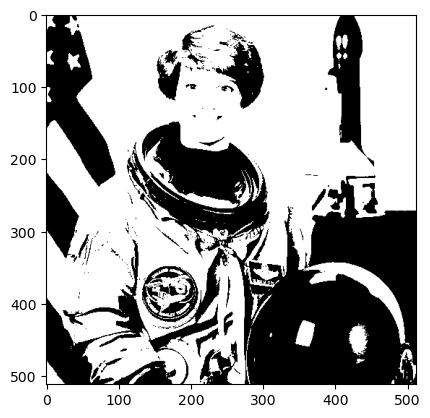

In [95]:
print(img.shape)
thres = threshold_otsu_impl(img*255)
print(thres)
nimg = thresholding(img*255, thres)
plt.imshow(nimg, cmap='gray')

**skimage.filters.threshold_otsu**(image=None, nbins=256, *, hist=None). Return threshold value based on Otsu’s method.
* image: ndarray, optional. Grayscale input image.
* nbins: int, optional. Number of bins used to calculate histogram. This value is ignored for integer arrays.
* hist: array, or 2-tuple of arrays, optional. Histogram from which to determine the threshold, and optionally a corresponding array of bin center intensities. If no hist provided, this function will compute it from the image.

Returns
* threshold: float. Upper threshold value. All pixels with an intensity higher than this value are assumed to be foreground.

In [96]:
def Otsu(img):
    h, _ = exposure.histogram(img)
    p = h / np.sum(h)
    omega = np.cumsum(p)
    x = p*np.arange(0, np.prod(h.shape) )
    mu = np.cumsum(x )
    muT = mu[-1]
    sigma_b = (muT * omega - mu)**2 / (omega * (1-omega) + np.finfo(float).eps)
    m = np.max( sigma_b )
    T = np.mean( np.where(sigma_b == m) )
    return T/254

In [97]:
def otsu_threshold_img(img):
    N = 256
    h, _ = np.histogram(img, bins=256)
    hn = h / np.sum(h)
    wb = np.cumsum(hn)
    wf = 1 - wb 
    ind = np.arange( 0, N )
    ind_h = h * ind
    mx = np.cumsum(ind_h)
    mean_h = np.cumsum(h)
    ub = mx / mean_h
    sigma = np.zeros((N))
    uf = np.zeros((N))
    for i in range(1,N):
        if i == N-1:
            break;
        uf[i] = np.sum(ind_h[i+1:]) / np.sum(h[i+1:])
    
        sigma[i] = wb[i]*wf[i]*(ub[i]-uf[i])**2
    m = np.argmax(sigma)/255
    return m

In [98]:
def Otsu_sk(img):
    counts, bin_centers = exposure.histogram(img)
    weight1 = np.cumsum(counts)
    weight2 = np.cumsum(counts[::-1])[::-1]
    # class means for all possible thresholds
    mean1 = np.cumsum(counts * bin_centers) / weight1
    mean2 = (np.cumsum((counts * bin_centers)[::-1]) / weight2[::-1])[::-1]

    # Clip ends to align class 1 and class 2 variables:
    # The last value of ``weight1``/``mean1`` should pair with zero values in
    # ``weight2``/``mean2``, which do not exist.
    variance12 = weight1[:-1] * weight2[1:] * (mean1[:-1] - mean2[1:]) ** 2

    idx = np.argmax(variance12)
    threshold = bin_centers[idx]
    return threshold

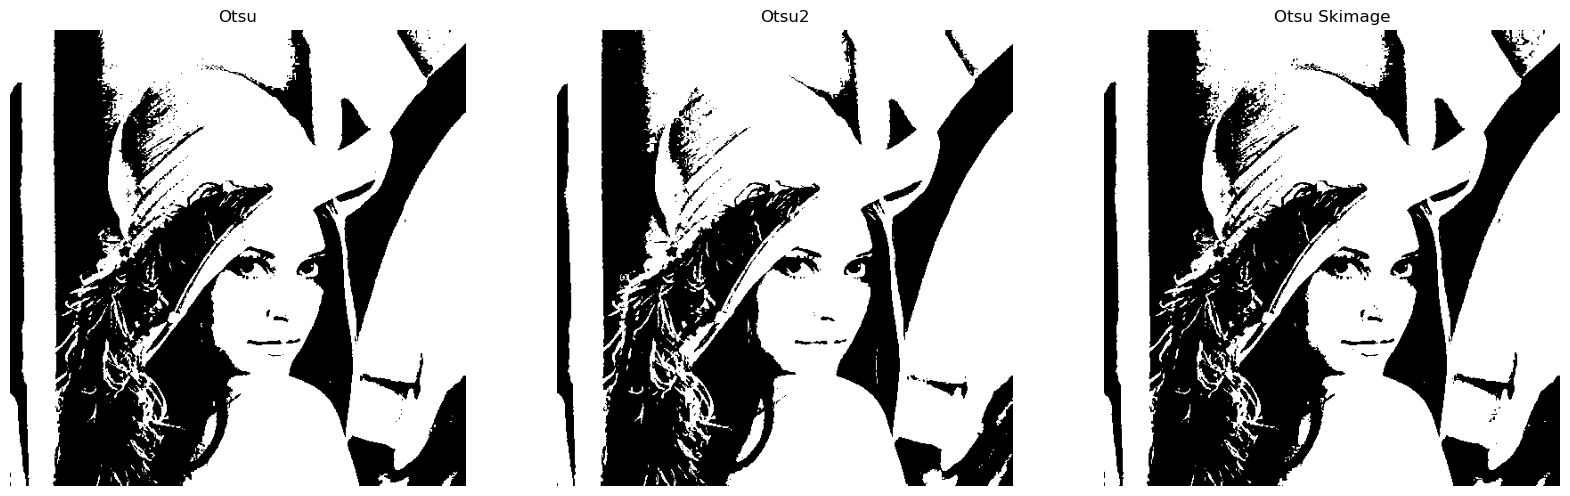

In [99]:
lenna = io.imread('D:\\Dropbox\\UFOP\\BCC326\\test\\png\\lenna_gray512.png', as_gray=True)
T = otsu_threshold_img(lenna)
T2 = Otsu(lenna)
t = filters.threshold_otsu(lenna)
show([lenna > T*255, lenna > T2*255, lenna > t], ['Otsu', 'Otsu2', 'Otsu Skimage'])



In [29]:
lenna = io.imread('D://Dropbox//UFOP//BCC326//test//png//lenna_gray512.png', as_gray=True)

## Threshold local

In [30]:
def localmean(img, footprint=np.ones((3,3)) ):
    footprint = footprint / np.sum(footprint)
    nimg = ndimage.convolve(img, footprint)
    return nimg

In [31]:
def localthresh(img, footprint=np.ones((3,3)), a=30, b=1.5, mean_type='global'):
    img_f = img_as_float(img.copy()) 
    SIG = ndimage.generic_filter(img_f, np.std, footprint=footprint)
    if mean_type == 'global':
        MEAN = np.mean(img_f)
    else:
        MEAN = localmean(img_f,footprint=footprint)

    nimg = np.logical_and( (img_f > a*SIG) , (img_f > b*MEAN) )
    return nimg, MEAN




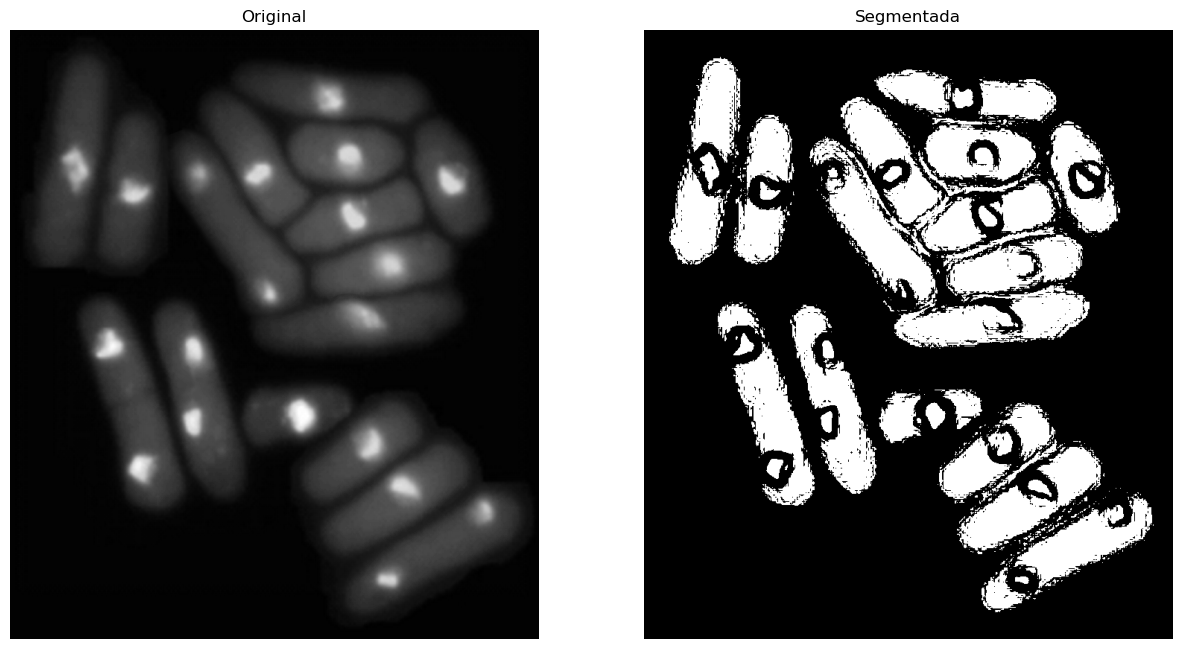

In [32]:
img = io.imread('D:\\Dropbox\\UFOP\\BCC326\\test\\png\\cells.png', as_gray=True)
nimg, MEAN = localthresh(img, footprint=np.ones((3,3)), a=30, b=1, mean_type='global')
show([img, nimg], ['Original', 'Segmentada'])

## Threshold Média

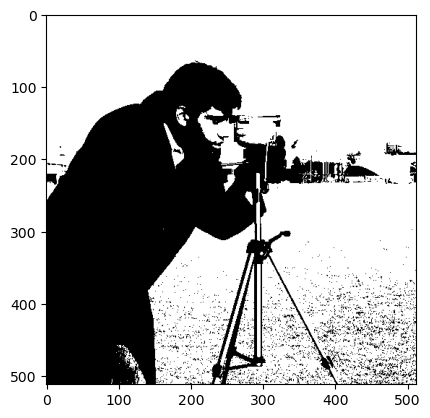

In [33]:
from skimage.data import camera
image = camera()
binary_image1 = image > filters.threshold_mean(image)
plt.imshow(binary_image1, cmap='gray')

## Region Growing

In [34]:
def distance(a, b):
    return np.abs(a - b)

def region_growing_average(img, img_t, tolerance, seed):
    x = seed[0]; y = seed[1]
    img_t[x,y] = 1

    avg = np.mean( img[np.where(img_t == 1)]  )

    if (y+1 < img.shape[1] and img_t[x,y+1] == 0 and distance(avg, img[x,y+1]) < tolerance):
        region_growing_average(img, img_t, tolerance, [x,y+1])

    if (y-1 >=0  and img_t[x,y-1] == 0 and distance(avg, img[x,y-1]) < tolerance):
        region_growing_average(img, img_t, tolerance, [x,y-1])

    if (x+1 < img.shape[0] and img_t[x+1,y] == 0 and distance(avg, img[x+1,y]) < tolerance):
        region_growing_average(img, img_t, tolerance, [x+1,y])

    if (x-1 >= 0 and img_t[x-1,y] == 0 and distance(avg, img[x-1,y]) < tolerance):
        region_growing_average(img, img_t, tolerance, [x-1,y])



In [35]:
img_test = np.zeros((15,15))
img_test[2:5, 4:12] = 100 + np.random.randint(0,3,(3,8))
img_test[5:13, 2:5] = 112 + np.random.randint(0,20,(8,3))



In [36]:
img_seed1 = np.zeros( img_test.shape )
img_seed2 = np.zeros( img_test.shape )
img_seed3 = np.zeros( img_test.shape )

region_growing_average(img_test, img_seed1, 8, (6,3))
region_growing_average(img_test, img_seed2, 16, (6,3))
region_growing_average(img_test, img_seed3, 24, (6,3))

Text(0.5, 1.0, '24')

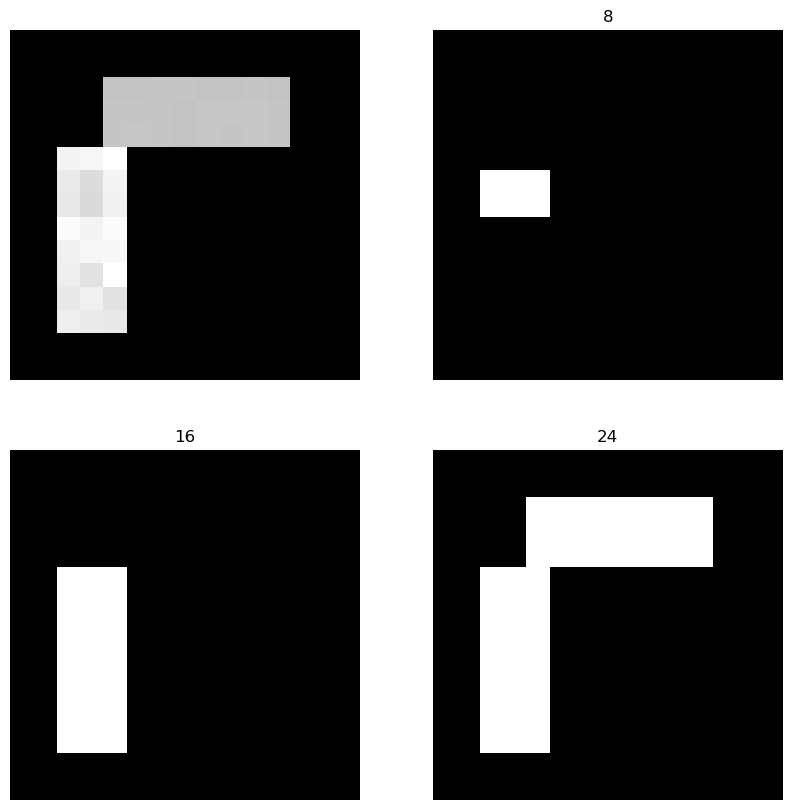

In [37]:
f,ax = plt.subplots(2,2, figsize=(10,10))
ax[0,0].imshow(img_test, cmap='gray'); ax[0,0].axis('off')
ax[0,1].imshow(img_seed1*255, cmap='gray'); ax[0,1].axis('off'); ax[0,1].set_title('8')
ax[1,0].imshow(img_seed2*255, cmap='gray'); ax[1,0].axis('off'); ax[1,0].set_title('16')
ax[1,1].imshow(img_seed3*255, cmap='gray'); ax[1,1].axis('off'); ax[1,1].set_title('24')

## Watershed

In [38]:
from skimage import morphology
from skimage.segmentation import watershed, random_walker
from skimage.feature import peak_local_max



In [39]:
img_test = np.zeros((15,15), dtype=np.uint8)

N = 5
img_test[2:5, 5:11] = 120 + ( np.random.randint(0,N,(3,6)) - N/2)
img_test[5:10, 9:14] = 170 + ( np.random.randint(0,N,(5,5)) - N/2)
img_test[5:13, 2:5] = 220 +  ( np.random.randint(0,N,(8,3)) - N/2)

#### Calcular a transformada de distancia
<p>A transformação de distância calcula a distância entre o fundo e os pixels do objeto. Valores máximos são o centro de massa dos objetos</p>

In [40]:
x = np.array([[0,0,0,0,0,0,0],
              [0,0,1,1,1,1,0],
              [0,1,1,1,1,1,0],
              [0,1,1,1,1,1,0],
              [0,1,1,1,1,1,0],
              [0,1,1,1,1,1,0],
              [0,0,0,0,0,0,0]])
np.set_printoptions(precision=2)
ndimage.distance_transform_edt(x)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 1.  , 1.  , 1.  , 1.  , 0.  ],
       [0.  , 1.  , 1.41, 2.  , 2.  , 1.  , 0.  ],
       [0.  , 1.  , 2.  , 2.83, 2.  , 1.  , 0.  ],
       [0.  , 1.  , 2.  , 2.  , 2.  , 1.  , 0.  ],
       [0.  , 1.  , 1.  , 1.  , 1.  , 1.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]])

In [41]:
distance_t = ndimage.distance_transform_edt(img_test)

(-0.5, 14.5, 14.5, -0.5)

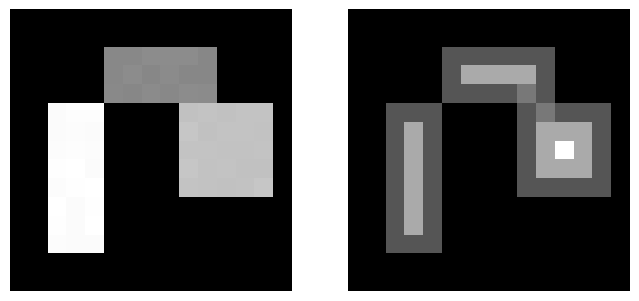

In [42]:
plt.figure( figsize=(8,4) )
plt.subplot(121);  plt.imshow(img_test, cmap='gray'); plt.axis('off')
plt.subplot(122);  plt.imshow(distance_t, cmap='gray'); plt.axis('off')


In [43]:
# calcula o máximo local a partir da transformada de distancia
#local_maxim = peak_local_max(distance_t, indices=False,footprint=np.ones((9,9)), labels=img_test)
coords = peak_local_max(distance_t, footprint=np.ones((9,9)), labels=img_test)
local_maxim = np.zeros(distance_t.shape, dtype=bool)
local_maxim[tuple(coords.T)] = True

# calculo os componentes conectados, e os etiqueta com valores distintos
seeds = morphology.label(local_maxim,)

Text(0.5, 1.0, 'Sementes')

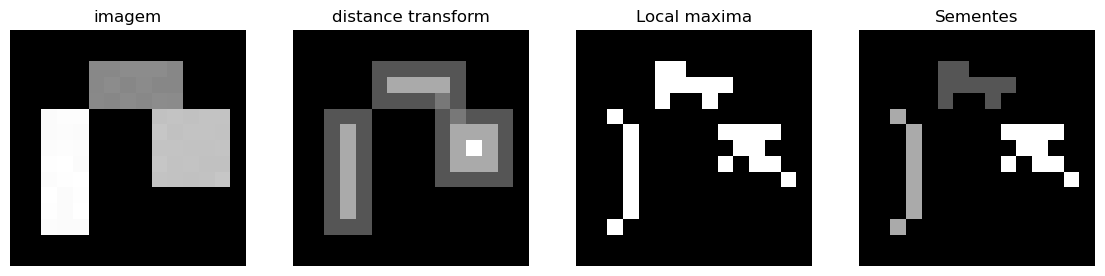

In [44]:
f,ax = plt.subplots(1,4, figsize=(14,6))
ax[0].imshow(img_test, cmap='gray'); ax[0].axis('off'); ax[0].set_title('imagem')
ax[1].imshow(distance_t, cmap='gray'); ax[1].axis('off'); ax[1].set_title('distance transform')
ax[2].imshow(local_maxim, cmap='gray'); ax[2].axis('off'); ax[2].set_title('Local maxima')
ax[3].imshow(seeds, cmap='gray'); ax[3].axis('off'); ax[3].set_title('Sementes')

In [45]:
segment = watershed(-distance_t, seeds, mask=img_test)

Text(0.5, 1.0, 'Watershed')

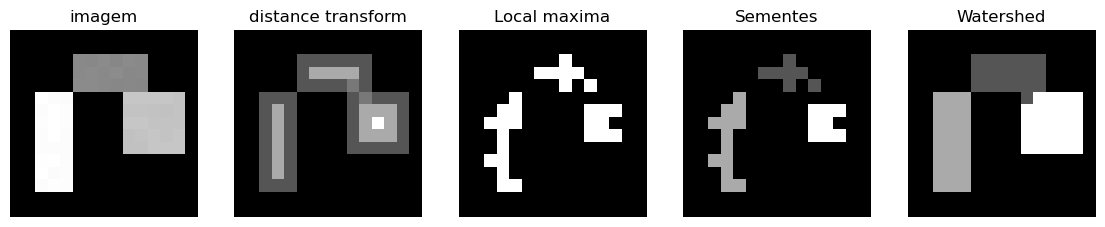

In [111]:
f,ax = plt.subplots(1,5, figsize=(14,6))
ax[0].imshow(img_test, cmap='gray'); ax[0].axis('off'); ax[0].set_title('imagem')
ax[1].imshow(distance_t, cmap='gray'); ax[1].axis('off'); ax[1].set_title('distance transform')
ax[2].imshow(local_maxim, cmap='gray'); ax[2].axis('off'); ax[2].set_title('Local maxima')
ax[3].imshow(seeds, cmap='gray'); ax[3].axis('off'); ax[3].set_title('Sementes')
ax[4].imshow(segment, cmap='gray'); ax[4].axis('off'); ax[4].set_title('Watershed')

In [46]:
img = io.imread('D:\\Dropbox\\UFOP\\BCC326\\test\\png\\lenna_gray512.png', as_gray=True)

no_seeds = 50
random_seeds = np.zeros(img.shape)
indices = np.random.randint(0, img.shape[0], [no_seeds, 2])
#indices = np.array([[40,60], [40,30],[100,150],[150,250], [300,110],[240,300],[450,300],[100,450],[200,475],[350,475],[450,475],[375,200],[50,375],[25,475],[100,8],[360,300],[120,380],[300,250]])

random_seeds[indices[:,0], indices[:,1]] = img[indices[:,0],indices[:,1]] 

random_seeds = morphology.dilation(random_seeds, morphology.disk(4)).astype(np.uint8)

In [47]:
img_dil = morphology.dilation(img, morphology.disk(1)).astype(np.uint8)
img_ero = morphology.erosion(img, morphology.disk(1)).astype(np.uint8)
img_grad = img_dil - img_ero


Text(0.5, 1.0, 'gradient')

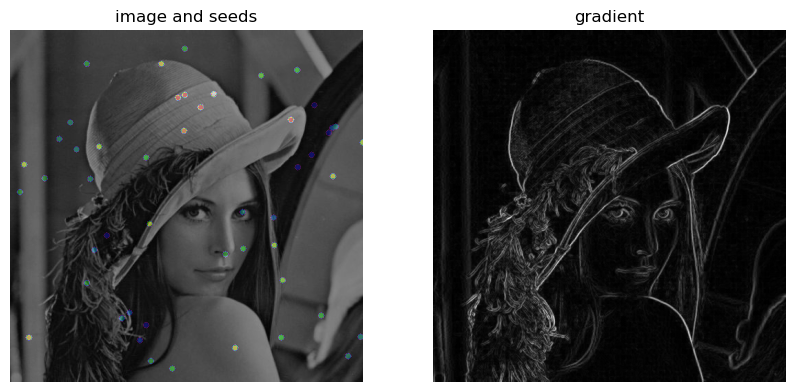

In [48]:
fig, axes = plt.subplots(1,2, figsize=(10,5), sharex=True, sharey=True)
ax = axes.ravel()
axes[0].imshow(img, cmap='gray'); axes[0].axis('off'); axes[0].set_title('image and seeds')
axes[0].imshow(random_seeds, cmap=plt.cm.nipy_spectral, alpha=.4)
axes[1].imshow(img_grad, cmap='gray'); axes[1].axis('off'); axes[1].set_title('gradient')

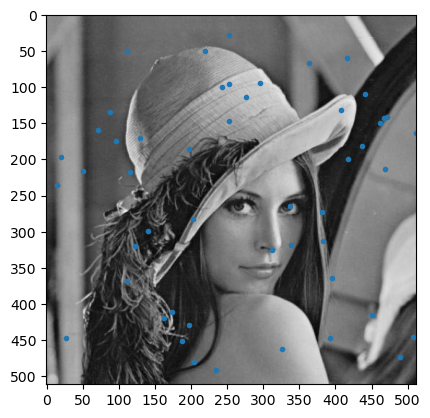

In [49]:
plt.imshow(img,cmap='gray')
plt.plot(indices[:,1], indices[:,0],'.')
plt.xticks(np.arange(0,512,50))
plt.yticks(np.arange(0,512,50))
plt.show()

In [50]:
img_segment = watershed(img_grad, random_seeds)

(-0.5, 511.5, 511.5, -0.5)

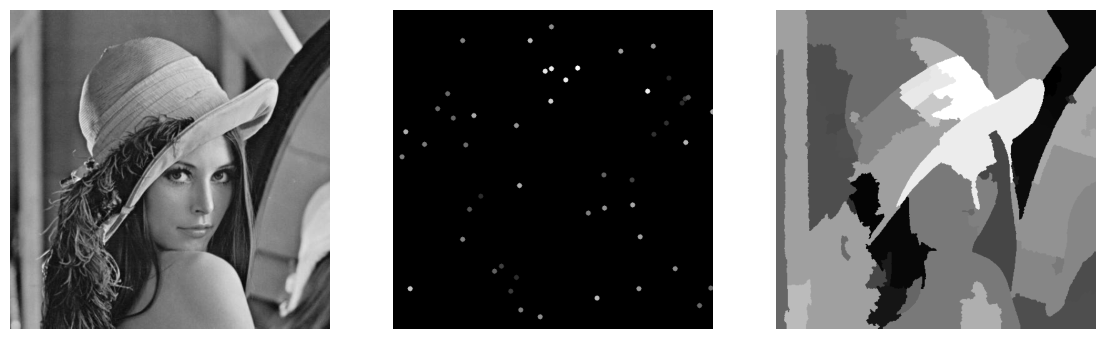

In [51]:
plt.figure(figsize=(14,6))
plt.subplot(131); plt.imshow(img, cmap='gray'); plt.axis('off')
plt.subplot(132); plt.imshow(random_seeds, cmap='gray'); plt.axis('off')
plt.subplot(133); plt.imshow(img_segment, cmap='gray'); plt.axis('off')

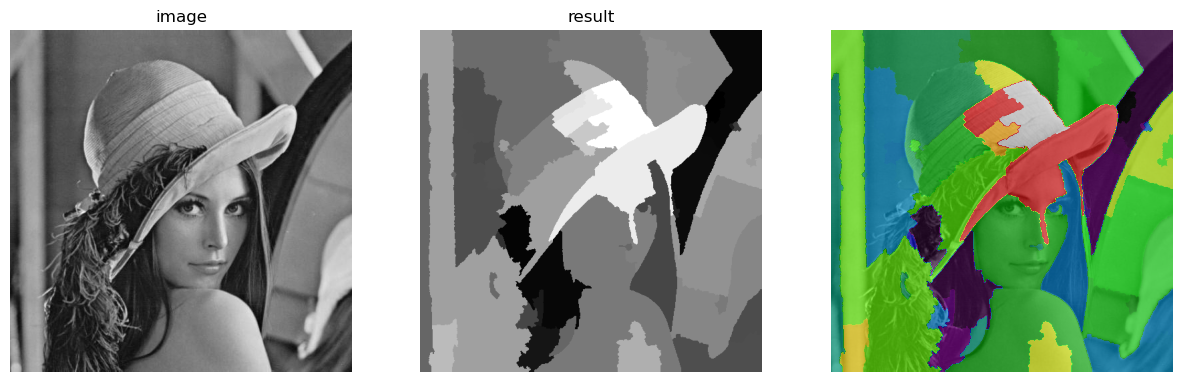

In [52]:
fig, axes = plt.subplots(1,3, figsize=(15,5), sharex=True, sharey=True)
ax = axes.ravel()
axes[0].imshow(img, cmap='gray'); axes[0].axis('off'); axes[0].set_title('image')
axes[1].imshow(img_segment, cmap='gray'); axes[1].axis('off'); axes[1].set_title('segmented regions')
axes[2].imshow(img, cmap='gray'); axes[2].axis('off'); axes[1].set_title('result')
axes[2].imshow(img_segment, cmap=plt.cm.nipy_spectral, alpha=.6)


## Transformada de Hough

<p>
<b>skimage.transform.hough_line</b>(image, theta=None): Perform a straight line Hough transform.

Parameters:
<ul>
    <li>image: (M, N) ndarray. Input image with nonzero values representing edges.</li>
    <li>theta: 1D ndarray of double, optional. Angles at which to compute the transform, in radians. Defaults to a vector of 180 angles evenly spaced in the range [-pi/2, pi/2).</li>
</ul>

Returns:
<ul>
    <li>h: space 2-D ndarray of uint64. Hough transform accumulator.</li>
    <li>angles: ndarray. Angles at which the transform is computed, in radians.</li>
    <li>distances: ndarray. Distance values.</li>
</ul>
</p>

<p>
<b>skimage.transform.hough_line_peaks</b>(image, theta=None): (hspace, angles, dists, min_distance=9, min_angle=10, threshold=None, num_peaks=inf). Return peaks in a straight line Hough transform.

Identifies most prominent lines separated by a certain angle and distance in a Hough transform. Non-maximum suppression with different sizes is applied separately in the first (distances) and second (angles) dimension of the Hough space to identify peaks.

Parameters:
<ul>
    <li>hspace: (N, M) array. Hough space returned by the hough_line function.</li>
    <li>angles: (M,) array. Angles returned by the hough_line function. Assumed to be continuous. (angles[-1] - angles[0] == PI).</li>
    <li>dists: (N, ) array. Distances returned by the hough_line function.</li>
    <li>min_distance: int, optional. Minimum distance separating lines (maximum filter size for first dimension of hough space).</li>
    <li>min_angle: int, optional. Minimum angle separating lines (maximum filter size for second dimension of hough space).</li>
    <li>threshold: float, optional. Minimum intensity of peaks. Default is 0.5 * max(hspace).</li>
    <li>num_peaks: int, optional. Maximum number of peaks. When the number of peaks exceeds num_peaks, return num_peaks coordinates based on peak intensity.</li>
</ul>

Returns:
<ul>
    <li>accum, angles, dists: tuple of array. Peak values in Hough space, angles and distances</li>
</ul>
</p>

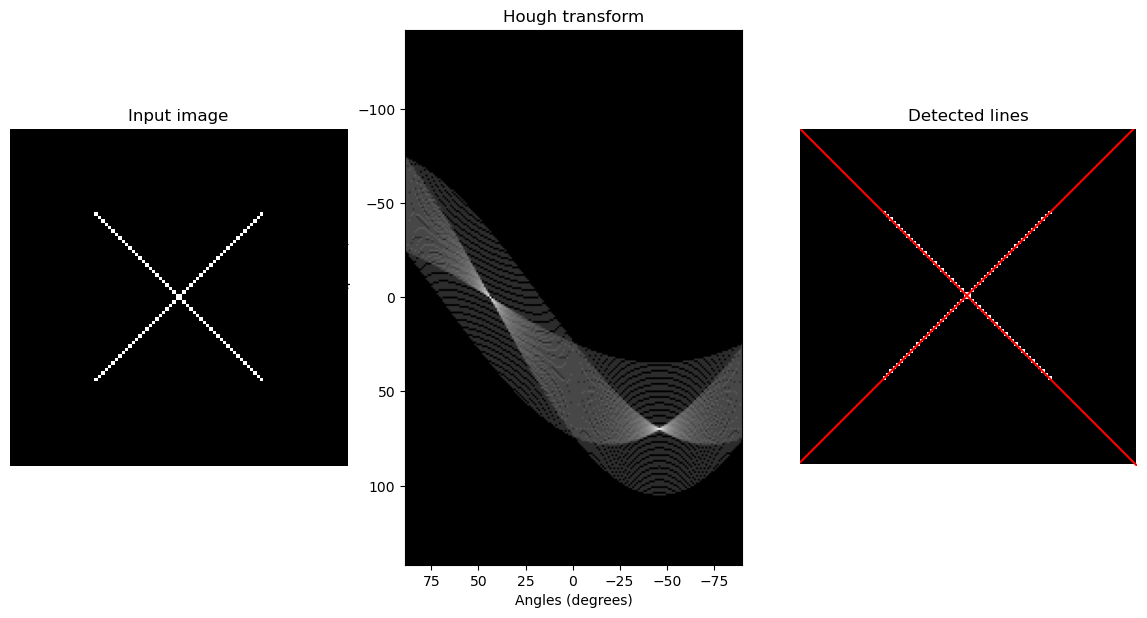

In [53]:
from matplotlib import cm
from skimage.transform import (hough_line, hough_line_peaks,
                               probabilistic_hough_line)
from skimage.feature import canny
from skimage import data

import numpy as np
import matplotlib.pyplot as plt

# Constructing test image.
image = np.zeros((100, 100))
idx = np.arange(25, 75)
image[idx[::-1], idx] = 255
image[idx, idx] = 255

# Classic straight-line Hough transform.
h, theta, d = hough_line(image)

# Generating figure 1.
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(12, 6))
plt.tight_layout()

ax0.imshow(image, cmap=cm.gray)
ax0.set_title('Input image')
ax0.set_axis_off()

ax1.imshow(np.log(1 + h), extent=[np.rad2deg(theta[-1]), np.rad2deg(theta[0]),
           d[-1], d[0]], cmap=cm.gray, aspect=1/1.5)
ax1.set_title('Hough transform')
ax1.set_xlabel('Angles (degrees)')
ax1.set_ylabel('Distance (pixels)')
ax1.axis('image')

ax2.imshow(image, cmap=cm.gray)
row1, col1 = image.shape
for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
    y1 = (dist - col1 * np.cos(angle)) / np.sin(angle)
    ax2.plot((0, col1), (y0, y1), '-r')
ax2.axis((0, col1, row1, 0))
ax2.set_title('Detected lines')
ax2.set_axis_off()

In [54]:
for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
    y1 = (dist - col1 * np.cos(angle)) / np.sin(angle)
    print([(0, col1), (y0, y1)])

[(0, 100), (98.99494936611664, -1.0050506338833503)]
[(0, 100), (-0.0, 100.0)]


https://medium.com/@tomasz.kacmajor/hough-lines-transform-explained-645feda072ab

In [55]:
img = io.imread('D:\\Dropbox\\UFOP\\BCC326\\Python\\11.Segmentacao\\predio.png')

In [56]:
from skimage import filters

C:\Users\Memo\AppData\Local\Temp\ipykernel_32844\819643859.py:1: FutureWarning: Automatic detection of the color channel was deprecated in v0.19, and `channel_axis=None` will be the new default in v0.21. Set `channel_axis=-1` explicitly to silence this warning.
  blurred = filters.gaussian(img, sigma=1  )


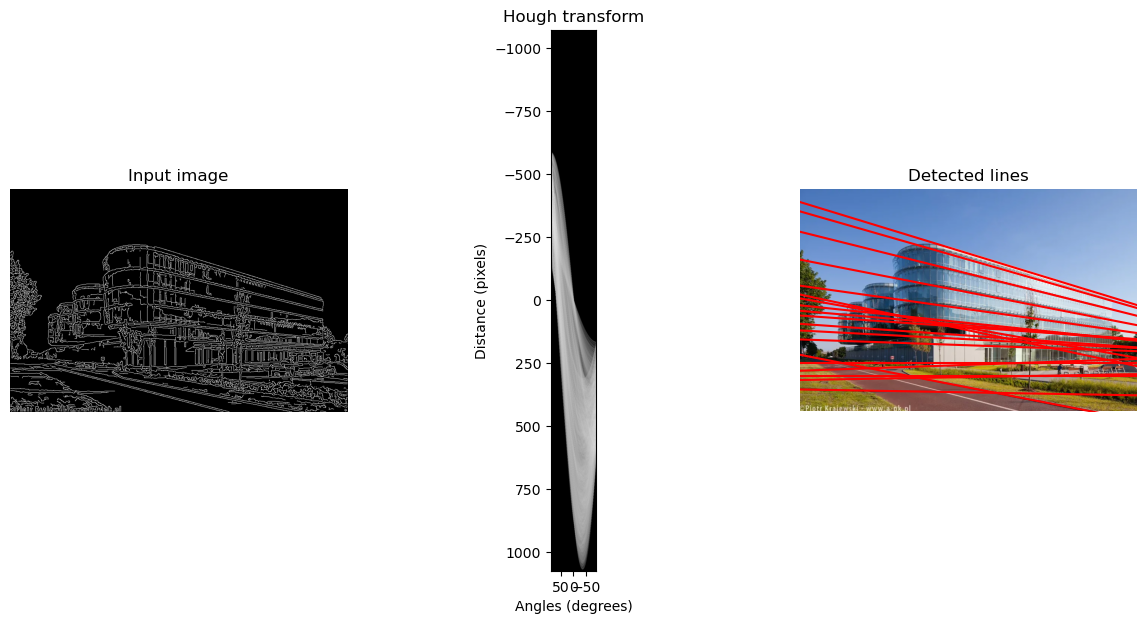

In [57]:
blurred = filters.gaussian(img, sigma=1  )
image = feature.canny(color.rgb2gray(blurred)) 
# Classic straight-line Hough transform.
h, theta, d = hough_line(image)

# Generating figure 1.
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(12, 6))
plt.tight_layout()

ax0.imshow(image, cmap=cm.gray)
ax0.set_title('Input image')
ax0.set_axis_off()

ax1.imshow(np.log(1 + h), extent=[np.rad2deg(theta[-1]), np.rad2deg(theta[0]),
           d[-1], d[0]], cmap=cm.gray, aspect=1/1.5)
ax1.set_title('Hough transform')
ax1.set_xlabel('Angles (degrees)')
ax1.set_ylabel('Distance (pixels)')
ax1.axis('image')

ax2.imshow(img, cmap=cm.gray)
row1, col1 = image.shape
r = 1
for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
    y1 = (dist - col1 * np.cos(angle)) / np.sin(angle)
    ax2.plot((0, col1), (y0, y1), '-r')
    #r += 1
    #if r == 15:
    #    break
ax2.axis((0, col1, row1, 0))
ax2.set_title('Detected lines')
ax2.set_axis_off()

In [58]:
img = io.imread('D:\\Dropbox\\UFOP\\BCC326\\Python\\11.Segmentacao\\road.jpg')

C:\Users\Memo\AppData\Local\Temp\ipykernel_32844\4169970644.py:1: FutureWarning: Automatic detection of the color channel was deprecated in v0.19, and `channel_axis=None` will be the new default in v0.21. Set `channel_axis=-1` explicitly to silence this warning.
  blurred = filters.gaussian(img, sigma=1  )


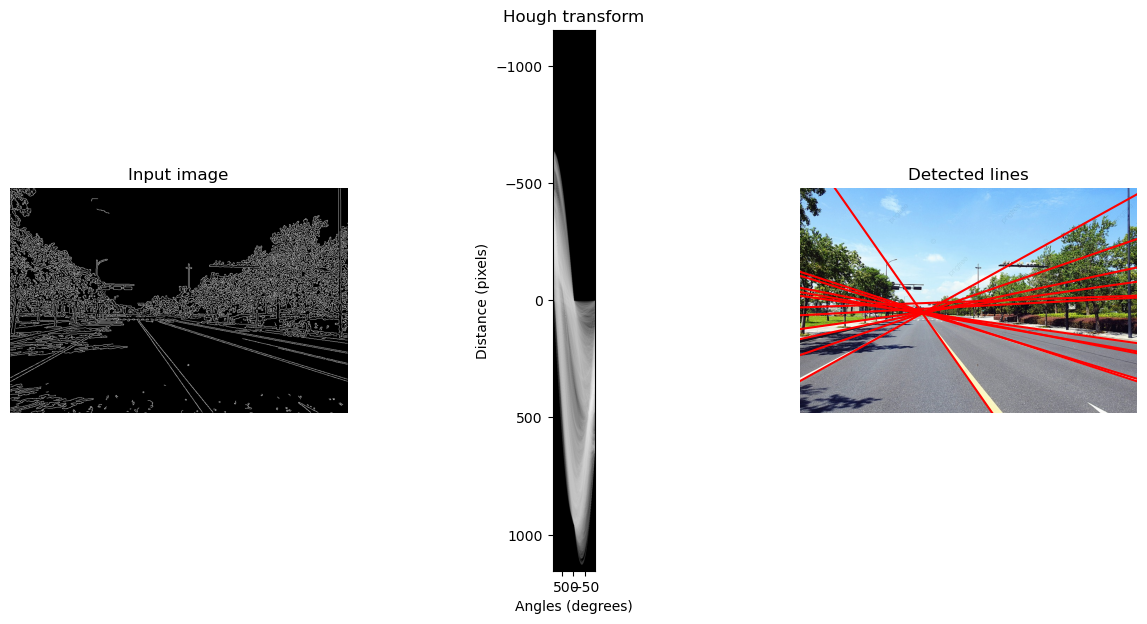

In [59]:
blurred = filters.gaussian(img, sigma=1  )
image = feature.canny(color.rgb2gray(blurred)) 
# Classic straight-line Hough transform.
h, theta, d = hough_line(image)

# Generating figure 1.
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(12, 6))
plt.tight_layout()

ax0.imshow(image, cmap=cm.gray)
ax0.set_title('Input image')
ax0.set_axis_off()

ax1.imshow(np.log(1 + h), extent=[np.rad2deg(theta[-1]), np.rad2deg(theta[0]),
           d[-1], d[0]], cmap=cm.gray, aspect=1/1.5)
ax1.set_title('Hough transform')
ax1.set_xlabel('Angles (degrees)')
ax1.set_ylabel('Distance (pixels)')
ax1.axis('image')

ax2.imshow(img, cmap=cm.gray)
row1, col1 = image.shape
r = 1
for _, angle, dist in zip(*hough_line_peaks(h, theta, d, threshold=0.69 * h.max())):
    y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
    y1 = (dist - col1 * np.cos(angle)) / np.sin(angle)
    ax2.plot((0, col1), (y0, y1), '-r')
    #r += 1
    #if r == 15:
    #    break
ax2.axis((0, col1, row1, 0))
ax2.set_title('Detected lines')
ax2.set_axis_off()